## Task 2 – Russian Cities Housing Challenge 2025
ERP: 29005


## 1. Load Libraries & Dataset

In [13]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import GradientBoostingRegressor

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

import matplotlib.pyplot as plt

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

print("Train shape:", train.shape)
print("Test shape:", test.shape)



Train shape: (181507, 279)
Test shape: (77789, 278)


## 2. Column Types

In [14]:
X = train.drop("price_doc", axis=1)
y = train["price_doc"]

num_cols = X.select_dtypes(include=[np.number]).columns
cat_cols = X.select_dtypes(include=['object']).columns

print(len(num_cols), "numeric columns")
print(len(cat_cols), "categorical columns")

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.30, random_state=29005
)


263 numeric columns
15 categorical columns


## 3. Preprocessing Pipeline

In [15]:
numeric_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ordinal", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
])

preprocess = ColumnTransformer([
    ("num", numeric_pipe, num_cols),
    ("cat", categorical_pipe, cat_cols)
])


In [16]:
def MSE(model, Xv, yv):
    pred = model.predict(Xv)
    return mean_squared_error(yv, pred)


## 4. Train All Models

## XGBOOST !!!

In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

n_list = [20, 40, 60, 80, 100, 120, 150, 200, 300]

results = {}

print("\nTuning n_estimators...\n")

for n in n_list:
    model = Pipeline([
        ("prep", preprocess),
        ("model", XGBRegressor(
            n_estimators=n,
            learning_rate=0.05,
            max_depth=6,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=29005,
            tree_method="hist",
            eval_metric="rmse"
        ))
    ])
    
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    
    rmse = np.sqrt(mean_squared_error(y_val, preds))
    results[n] = rmse
    
    print(f"n_estimators={n} → RMSE: {rmse:.4f}")

# Best value
best_n = min(results, key=results.get)
print("\nBest n_estimators =", best_n, "with RMSE =", results[best_n])



Tuning n_estimators...

n_estimators=20 → RMSE: 15.1297
n_estimators=40 → RMSE: 13.0463
n_estimators=60 → RMSE: 12.7392
n_estimators=80 → RMSE: 12.7090
n_estimators=100 → RMSE: 12.7101
n_estimators=120 → RMSE: 12.7271
n_estimators=150 → RMSE: 12.7443
n_estimators=200 → RMSE: 12.7567
n_estimators=300 → RMSE: 12.7920

Best n_estimators = 80 with RMSE = 12.709038476026157


In [32]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

n_list = [101]

results = {}

print("\nTuning n_estimators...\n")

for n in n_list:
    model = Pipeline([
        ("prep", preprocess),
        ("model", XGBRegressor(
            n_estimators=n,
            learning_rate=0.05,
            max_depth=6,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=29005,
            tree_method="hist",
            eval_metric="rmse"
        ))
    ])
    
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    
    rmse = np.sqrt(mean_squared_error(y_val, preds))
    results[n] = rmse
    
    print(f"n_estimators={n} → RMSE: {rmse:.4f}")

# Best value
best_n = min(results, key=results.get)
print("\nBest n_estimators =", best_n, "with RMSE =", results[best_n])



Tuning n_estimators...

n_estimators=101 → RMSE: 12.7098

Best n_estimators = 101 with RMSE = 12.709799811540323


## 5. MSE & RMSE Comparison Chart

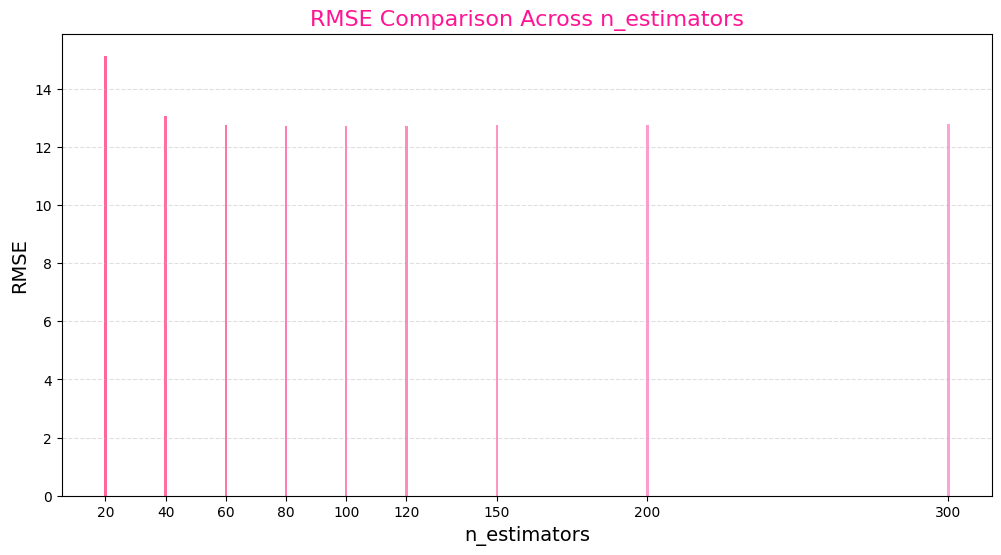

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

n_values = list(results.keys())
rmse_values = list(results.values())

# Generate shades of pink
pink_colors = [ (1, 0.4 + i*0.03, 0.6 + i*0.03) for i in range(len(n_values)) ]
# Values stay in RGB range and create a pink gradient

plt.figure(figsize=(12,6))
plt.bar(n_values, rmse_values, color=pink_colors)

plt.title("XGB RMSE Comparison Across n_estimators", fontsize=16, color="#ff1493")
plt.xlabel("n_estimators", fontsize=14)
plt.ylabel("RMSE", fontsize=14)

plt.xticks(n_values)
plt.grid(axis='y', linestyle='--', alpha=0.4)

plt.show()



In [30]:
from xgboost import XGBRegressor

final_model = Pipeline([
    ("prep", preprocess),
    ("model", XGBRegressor(
        n_estimators=101,       # from tuning
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=29005,
        tree_method="hist",
        eval_metric="rmse"
    ))
])

print("\nTraining final model on ALL DATA...")
final_model.fit(X, y)
print("✔ Final model trained successfully!")



Training final model on ALL DATA...
✔ Final model trained successfully!


## 7. Kaggle Submission File

In [31]:
print("\nProcessing test.csv using Pipeline...")

# Pipeline handles encoding automatically
test_processed = test.copy()

print("Test preprocessing done ✔ (handled by pipeline)")

# ---- Predict ----
print("\nPredicting on test.csv...")
preds = final_model.predict(test_processed)

# ---- Create Kaggle submission ----
submission = pd.DataFrame({
    "id": test["id"],
    "price_doc": preds
})

submission.to_csv("submission_task2.csv", index=False)
print("\n submission_task2.csv created successfully ✔")



Processing test.csv using Pipeline...
Test preprocessing done ✔ (handled by pipeline)

Predicting on test.csv...

 submission_task2.csv created successfully ✔
